In [11]:
import os
import argparse
import yaml
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch
import torch.nn.functional as F

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from models import get_model
from utils import trust_scores
from metrics import Metrics
import utils.logger
LOGGER = utils.logger.get_logger(__name__, level='DEBUG')

np.random.seed(42)
torch.manual_seed(42)

## Load normal model

In [12]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/svhn/trustscore/svhn_trustscore_baseline/config_1.yaml'
epoch = 17
#config_path = '/share/DEEPLEARNING/ccorbiere/logs/mnist/paper/mnist_mlp_baseline_dropout/config_1.yaml'
#epoch = 130
mode = 'mc_dropout'
samples = 100

In [13]:
with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']
    if config_args['training']['learner'] in ['segmentation', 'selfconfid-segmentation']:
        config_args['training']['metrics'].append('mean_iou')

config_args['data']['is_test'] = True
config_args['model']['feature_dim'] = 512

# Special case of MC Dropout
if mode == 'mc_dropout':
    config_args['training']['mc_dropout'] = True
    
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load dataset
LOGGER.info('Loading dataset {}'.format(config_args['data']['dataset']))
dloader = get_loader(config_args, generating=True)

# Make loaders
dloader.make_loaders()

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_normal = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_normal.model.load_state_dict(checkpoint['model_state_dict'])

# Get scores
LOGGER.info('Inference mode: {}'.format(mode))

if not hasattr(checkpoint, 'prod_test_len'):
    learner_normal.prod_test_len = learner_normal.nsamples_test

2019-05-21 14:53:18,177 gpuserver2 __main__[10461] INFO Loading dataset svhn
2019-05-21 14:53:18,178 gpuserver2 loaders.loader[10461] INFO --- Augmentations ---
2019-05-21 14:53:18,178 gpuserver2 augmentations[10461] INFO Using No Augmentations


Using downloaded and verified file: data/svhn-data/train_32x32.mat
Using downloaded and verified file: data/svhn-data/test_32x32.mat


2019-05-21 14:53:21,781 gpuserver2 loaders.loader[10461] WARNING Loading existing train-val split indices
2019-05-21 14:53:21,792 gpuserver2 __main__[10461] WARNING Learning type: default
2019-05-21 14:53:21,813 gpuserver2 learners.learner[10461] INFO Using optimizer sgd
2019-05-21 14:53:21,813 gpuserver2 schedulers[10461] INFO Using No LR Scheduling
2019-05-21 14:53:21,833 gpuserver2 __main__[10461] INFO Inference mode: mc_dropout


## Load selfconfid model

In [14]:
config_path = '/share/DEEPLEARNING/ccorbiere/logs/svhn/paper/svhn_selfconfid_classic_adam_lr4_mse/config_1.yaml'
epoch = 217
#config_path = '/share/DEEPLEARNING/ccorbiere/logs/mnist/paper/mnist_mlp_selfconfid_adamlr4_mse/config_1.yaml'
#epoch = 393

In [15]:
with open(config_path, 'r') as f:
    config_args = yaml.load(f, Loader=yaml.SafeLoader)
    config_args['training']['metrics'] = ['accuracy', 'auc', 'ap_success', 'ap_errors']
    if config_args['training']['learner'] in ['segmentation', 'selfconfid-segmentation']:
        config_args['training']['metrics'].append('mean_iou')
        
config_args['model']['feature_dim'] = 512

# Set learner
LOGGER.warning('Learning type: {}'.format(config_args['training']['learner']))
learner_selfconfid = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, device)

# Load model
# Initialize and load model
ckpt_path = os.path.join(config_args['training']['output_folder'], 'model_epoch_{:03d}.ckpt'.format(epoch))
checkpoint = torch.load(ckpt_path)
learner_selfconfid.model.load_state_dict(checkpoint['model_state_dict'])

if not hasattr(learner_selfconfid, 'prod_test_len'):
    learner_selfconfid.prod_test_len = learner_selfconfid.nsamples_test

2019-05-21 14:53:21,877 gpuserver2 __main__[10461] WARNING Learning type: selfconfid
2019-05-21 14:53:21,903 gpuserver2 learners.learner[10461] INFO Using optimizer adam
2019-05-21 14:53:21,904 gpuserver2 schedulers[10461] INFO Using No LR Scheduling
2019-05-21 14:53:21,905 gpuserver2 learners.selfconfid_learner[10461] INFO Freezing every layer except uncertainty
2019-05-21 14:53:21,906 gpuserver2 learners.selfconfid_learner[10461] INFO Keeping original BN parameters


uncertainty1.weight kept to training
uncertainty1.bias kept to training
uncertainty2.weight kept to training
uncertainty2.bias kept to training
uncertainty3.weight kept to training
uncertainty3.bias kept to training
uncertainty4.weight kept to training
uncertainty4.bias kept to training
uncertainty5.weight kept to training
uncertainty5.bias kept to training
conv1_bn original BN setting
conv2_bn original BN setting
dropout1 set to eval mode
conv3_bn original BN setting
conv4_bn original BN setting
dropout2 set to eval mode
conv5_bn original BN setting
conv6_bn original BN setting
dropout3 set to eval mode
dropout4 set to eval mode


In [16]:
mode = 'mc_dropout'

In [17]:
learner_normal.model.eval()
metrics_normal = Metrics(learner_normal.metrics, learner_normal.prod_test_len, config_args['data']['num_classes'])
total_probs_normal = []

learner_selfconfid.model.eval()
metrics_selfconfid = Metrics(learner_selfconfid.metrics, learner_selfconfid.prod_test_len, config_args['data']['num_classes'])
total_probs_selfconfid = []

# Special case of mc-dropout
if mode == 'mc_dropout':
    learner_normal.model.keep_dropout_in_test()
    LOGGER.info('Sampling {} times'.format(samples))
        
with torch.no_grad():
    loop = tqdm(dloader.test_loader, disable=False)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)

        if mode == 'normal':
            output = learner_normal.model(data)
            probs = F.softmax(output, dim=1)
            confidence, pred = probs.max(dim=1, keepdim=True)
            
        elif mode == 'entropy':
            output = learner_normal.model(data)
            probs = F.softmax(output, dim=1)
            confidence = ((probs * torch.log(probs + 1e-9)).sum(dim=1))
            pred = probs.max(dim=1, keepdim=True)[1]

        elif mode == 'gt':
            output = learner_normal.model(data)
            output = F.softmax(output, dim=1)
            pred = output.max(dim=0, keepdim=True)
            labels_hot = utils.one_hot_embedding(target, config_args['data']['num_classes']).to(device)
            confidence, _ = (labels_hot*output).max(dim=1, keepdim=True)

        elif mode == 'mc_dropout':
            outputs = torch.zeros(samples, data.shape[0], config_args['data']['num_classes']).to(device)
            for i in range(samples):
                outputs[i] = learner_normal.model(data)
            output = outputs.mean(0)
            probs = F.softmax(output, dim=1)
            confidence = ((probs * torch.log(probs + 1e-9)).sum(dim=1)).unsqueeze(dim=1)
            pred = probs.max(dim=1, keepdim=True)[1]

        metrics_normal.update(pred, target, confidence)
        total_probs_normal.extend(probs.detach().cpu().numpy())
        
        # Self confid turn
        output = learner_selfconfid.model(data)
        pred = output[0].argmax(dim=1, keepdim=True)
        metrics_selfconfid.update(pred, target, torch.sigmoid(output[1]))
        
scores_normal = metrics_normal.get_scores(split='test')
scores_selfconfid = metrics_selfconfid.get_scores(split='test')
total_probs_normal = np.reshape(total_probs_normal, newshape=(len(total_probs_normal), len(total_probs_normal[0])))

2019-05-21 14:53:22,000 gpuserver2 models.model[10461] WARNING Keeping dropout activated during evaluation mode
2019-05-21 14:53:22,001 gpuserver2 __main__[10461] INFO Sampling 100 times


In [18]:
top_k_errors = np.where((metrics_normal.accurate==0) & (metrics_normal.proba_pred>-0.8) & (metrics_selfconfid.proba_pred<0.45))[0]

In [19]:
len(top_k_errors)

8

In [20]:
metrics_normal.proba_pred.min()

-2.1800683

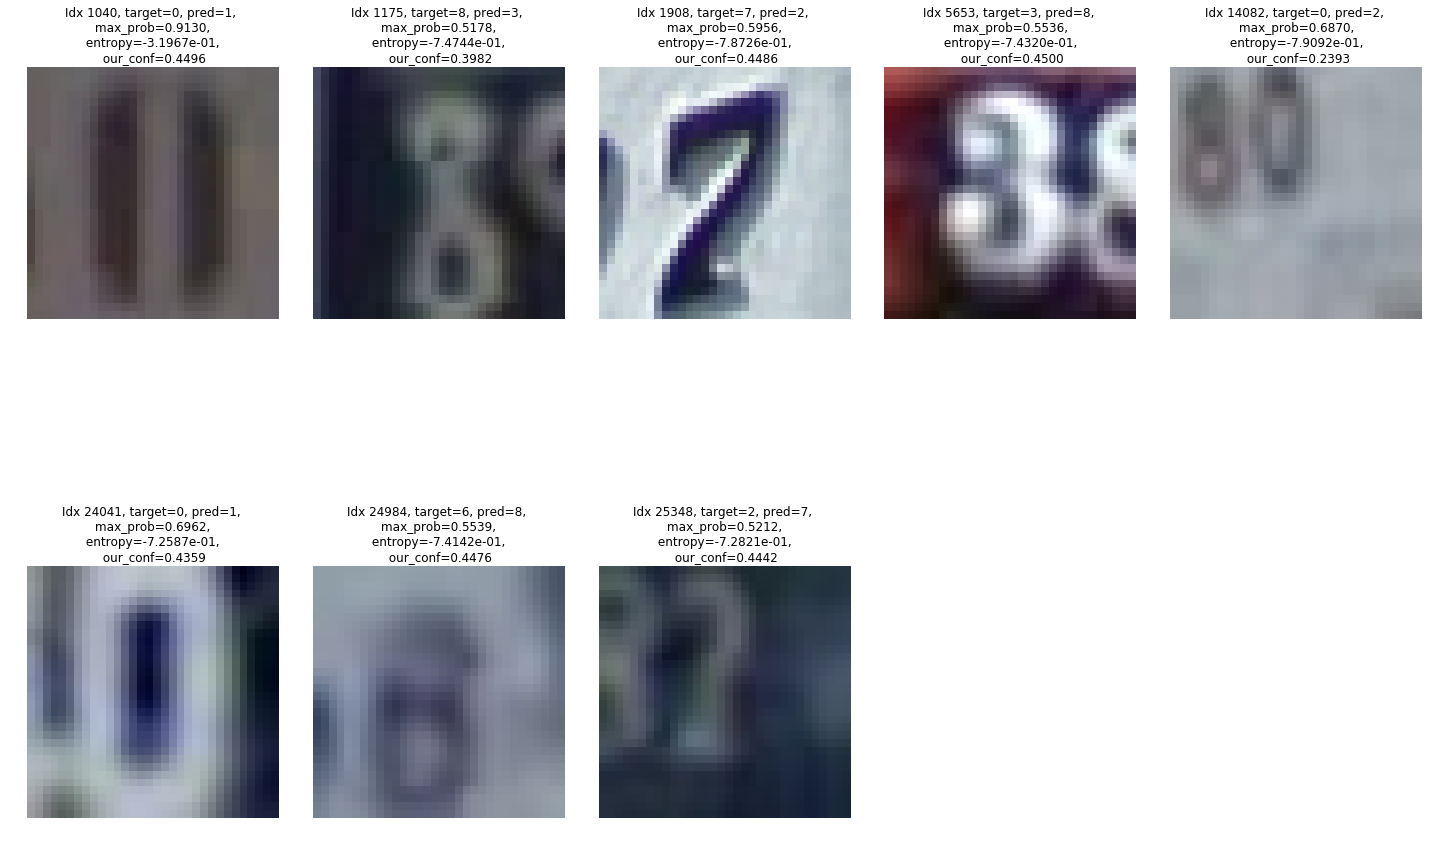

In [21]:
plt.figure(figsize=(20,15))
for i in range(len(top_k_errors)):
    plt.subplot(np.ceil(len(top_k_errors)/5), 5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i]],(1,2,0)))
    plt.title('Idx {}, target={}, pred={}, \n max_prob={:.4f}, \n entropy={:.4e}, \n our_conf={:.4f}'
              .format(top_k_errors[i], dloader.test_loader.dataset.labels[top_k_errors[i]],total_probs_normal[top_k_errors[i]].argmax(),
                      total_probs_normal[top_k_errors[i]].max(), metrics_normal.proba_pred[top_k_errors[i]], 
                      metrics_selfconfid.proba_pred[top_k_errors[i]]))
plt.tight_layout()
plt.show()

In [30]:
top_k_accurate1 = np.where((metrics_normal.accurate==1) & (metrics_normal.proba_pred>-0.789) & (metrics_normal.proba_pred<-0.786))[0]

In [31]:
len(top_k_accurate1)

7

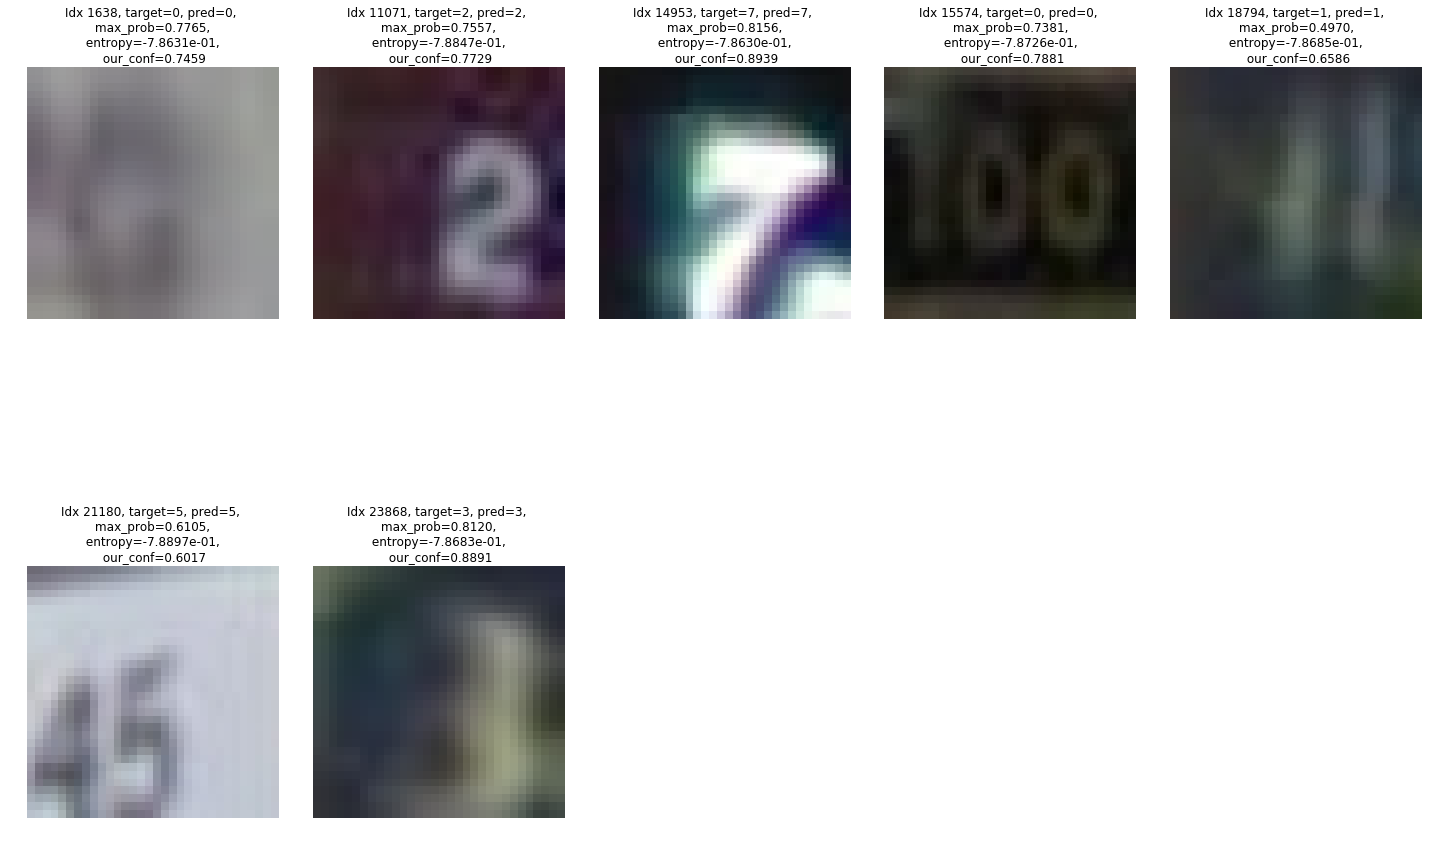

In [32]:
plt.figure(figsize=(20,15))
for i in range(len(top_k_accurate1)):
    plt.subplot(np.ceil(len(top_k_accurate1)/5), 5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(dloader.test_loader.dataset.data[top_k_accurate1[i]],(1,2,0)))
    plt.title('Idx {}, target={}, pred={}, \n max_prob={:.4f}, \n entropy={:.4e}, \n our_conf={:.4f}'
              .format(top_k_accurate1[i], dloader.test_loader.dataset.labels[top_k_accurate1[i]],
                      total_probs_normal[top_k_accurate1[i]].argmax(),
                      total_probs_normal[top_k_accurate1[i]].max(), metrics_normal.proba_pred[top_k_accurate1[i]], 
                      metrics_selfconfid.proba_pred[top_k_accurate1[i]]))
plt.tight_layout()
plt.show()

In [35]:
top_k_accurate2 = np.where((metrics_normal.accurate==1) & (metrics_normal.proba_pred>-0.727) & (metrics_normal.proba_pred<-0.725))[0]
print(len(top_k_accurate2))

7


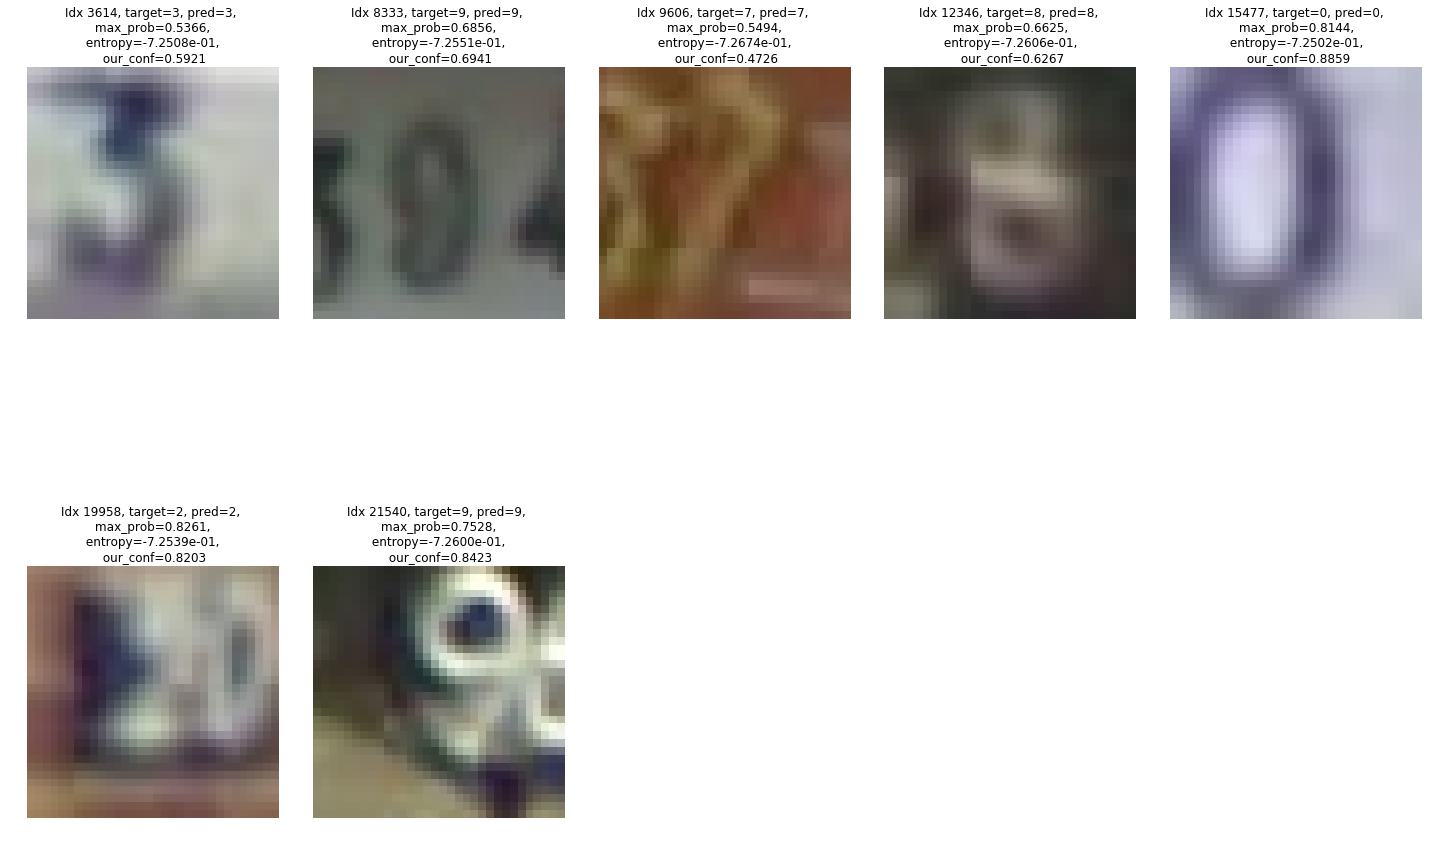

In [36]:
plt.figure(figsize=(20,15))
for i in range(len(top_k_accurate2)):
    plt.subplot(np.ceil(len(top_k_accurate2)/5), 5,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(dloader.test_loader.dataset.data[top_k_accurate2[i]],(1,2,0)))
    plt.title('Idx {}, target={}, pred={}, \n max_prob={:.4f}, \n entropy={:.4e}, \n our_conf={:.4f}'
              .format(top_k_accurate2[i], dloader.test_loader.dataset.labels[top_k_accurate2[i]],
                      total_probs_normal[top_k_accurate2[i]].argmax(),
                      total_probs_normal[top_k_accurate2[i]].max(), metrics_normal.proba_pred[top_k_accurate2[i]], 
                      metrics_selfconfid.proba_pred[top_k_accurate2[i]]))
plt.tight_layout()
plt.show()

In [43]:
i1= 2
i2= 5
j1= 2
j2 = 4

In [44]:
def frame_image(img,color):
    img = np.array(img)
    b = 1 # border size in pixel
    ny, nx = img.shape[0], img.shape[1] # resolution / number of pixels in x and y
    if img.ndim == 3: # rgb or rgba array
        framed_img = np.zeros((b+ny+b, b+nx+b, img.shape[2]), dtype=int)
    elif img.ndim == 2: # grayscale image
        framed_img = np.zeros((b+ny+b, b+nx+b))
        
    # Color
    if color=='red':
        framed_img[:,:,0] = 255
    elif color=='green':
        framed_img[:,:,1] = 255
        
    framed_img[b:-b, b:-b] = img
    return framed_img

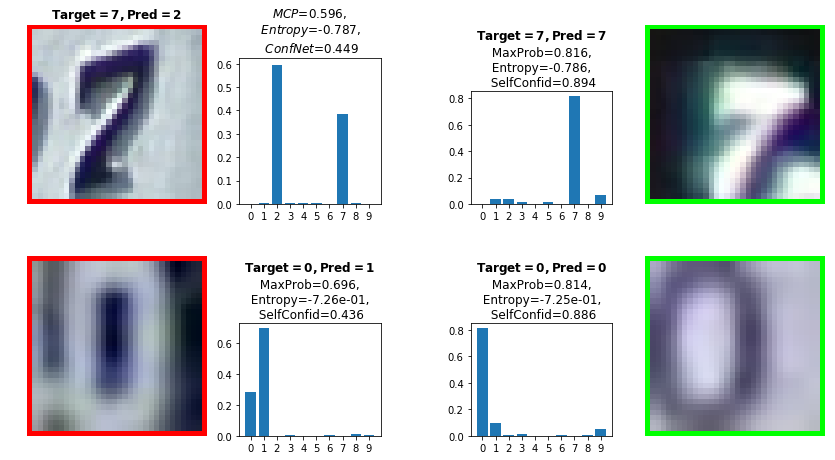

In [86]:
plt.figure(figsize=(15,10))
gridspec.GridSpec(33,11)
plt.subplot2grid((33,11), (0,0), colspan=3, rowspan=11)
plt.axis('off')
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_errors[i1]],
                                                total_probs_normal[top_k_errors[i1]].argmax()))
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i1]],(1,2,0)),'red'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[i1]],'red'))


plt.subplot2grid((33,11), (2,3), colspan=2, rowspan=9)
plt.title(r'$\it{MCP}$'+'={:.3f}, \n '.format(total_probs_normal[top_k_errors[i1]].max())
          +r'$\it{Entropy}$'+'={:.3f}, \n '.format(metrics_normal.proba_pred[top_k_errors[i1]])
          +r'$\it{ConfNet}$'+'={:.3f}'.format(metrics_selfconfid.proba_pred[top_k_errors[i1]]))
                  
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[i1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (4,6), colspan=2, rowspan=7)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate1[j1]],
                                                total_probs_normal[top_k_accurate1[j1]].argmax())
                  +'\n MaxProb={:.3f}, \n Entropy={:.3f}, \n SelfConfid={:.3f}'
          .format(total_probs_normal[top_k_accurate1[j1]].max(), metrics_normal.proba_pred[top_k_accurate1[j1]], 
                  metrics_selfconfid.proba_pred[top_k_accurate1[j1]]))
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate1[j1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,8), colspan=3, rowspan=11)
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate1[j1]],(1,2,0)),'green'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[j1]],'red'))


#########################################################################################

plt.subplot2grid((33,11), (14,0), colspan=3, rowspan=11)
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i2]],(1,2,0)),'red'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[i2]],'red'))

plt.subplot2grid((33,11), (18,3), colspan=2, rowspan=7)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_errors[i2]],
                                                total_probs_normal[top_k_errors[i2]].argmax())
                  +'\n MaxProb={:.3f}, \n Entropy={:.2e}, \n SelfConfid={:.3f}'
          .format(total_probs_normal[top_k_errors[i2]].max(), metrics_normal.proba_pred[top_k_errors[i2]], 
                  metrics_selfconfid.proba_pred[top_k_errors[i2]]))
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[i2]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (18,6), colspan=2, rowspan=7)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate2[j2]],
                                                total_probs_normal[top_k_accurate2[j2]].argmax())
                  +'\n MaxProb={:.3f}, \n Entropy={:.2e}, \n SelfConfid={:.3f}'
          .format(total_probs_normal[top_k_accurate2[j2]].max(), metrics_normal.proba_pred[top_k_accurate2[j2]], 
                  metrics_selfconfid.proba_pred[top_k_accurate2[j2]]))
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate2[j2]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (14,8), colspan=3, rowspan=11)
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate2[j2]],(1,2,0)),'green'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[j2]],'red'))

plt.show()


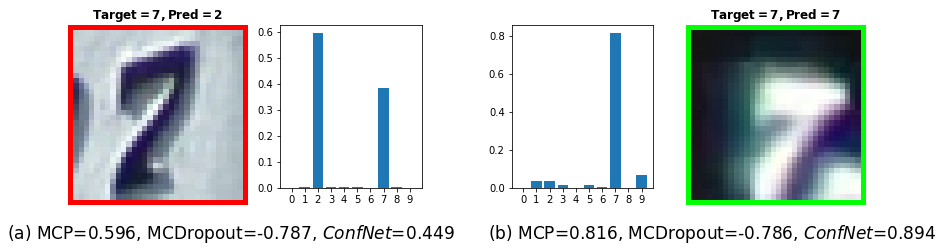

In [172]:
plt.figure(figsize=(15,10))
gridspec.GridSpec(33,11)
plt.subplot2grid((33,11), (0,0), colspan=3, rowspan=11)
plt.axis('off')
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_errors[i1]],
                                                total_probs_normal[top_k_errors[i1]].argmax()))
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i1]],(1,2,0)),'red'))
plt.text(x=-12, y=40, s='(a) MCP={:.3f}, '.format(total_probs_normal[top_k_errors[i1]].max())
          +'MCDropout={:.3f}, '.format(metrics_normal.proba_pred[top_k_errors[i1]])
          +r'$ConfNet$'+'={:.3f}'.format(metrics_selfconfid.proba_pred[top_k_errors[i1]]),
         fontsize=17)

plt.subplot2grid((33,11), (0,3), colspan=2, rowspan=10)                 
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[i1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,6), colspan=2, rowspan=10)
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate1[j1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,8), colspan=3, rowspan=11)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate1[j1]],
                                                total_probs_normal[top_k_accurate1[j1]].argmax()))
plt.axis('off')
plt.text(x=-38, y=40, s='(b) MCP={:.3f}, '.format(total_probs_normal[top_k_accurate1[j1]].max())
          +'MCDropout={:.3f}, '.format(metrics_normal.proba_pred[top_k_accurate1[j1]])
          +r'$\it{ConfNet}$'+'={:.3f}'.format(metrics_selfconfid.proba_pred[top_k_accurate1[j1]]),
         fontsize=17)
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate1[j1]],(1,2,0)),'green'))
plt.show()

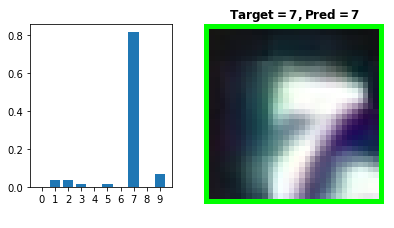

In [158]:
plt.figure(figsize=(15,10))
gridspec.GridSpec(33,11)
plt.subplot2grid((33,11), (0,6), colspan=2, rowspan=10)
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate1[j1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,8), colspan=3, rowspan=11)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate1[j1]],
                                                total_probs_normal[top_k_accurate1[j1]].argmax()))
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate1[j1]],(1,2,0)),'green'))
plt.show()

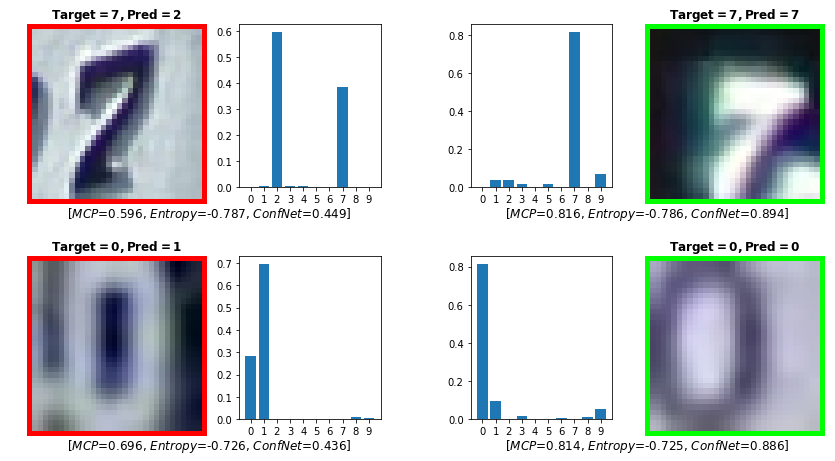

In [138]:
plt.figure(figsize=(15,10))
gridspec.GridSpec(33,11)
plt.subplot2grid((33,11), (0,0), colspan=3, rowspan=11)
plt.axis('off')
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_errors[i1]],
                                                total_probs_normal[top_k_errors[i1]].argmax()))
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i1]],(1,2,0)),'red'))
plt.text(x=7, y=36, s=r'[$\it{MCP}$'+'={:.3f}, '.format(total_probs_normal[top_k_errors[i1]].max())
          +r'$\it{Entropy}$'+'={:.3f}, '.format(metrics_normal.proba_pred[top_k_errors[i1]])
          +r'$\it{ConfNet}$'+'={:.3f}]'.format(metrics_selfconfid.proba_pred[top_k_errors[i1]]),
         fontsize=12)

plt.subplot2grid((33,11), (0,3), colspan=2, rowspan=10)                 
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[i1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,6), colspan=2, rowspan=10)
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate1[j1]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (0,8), colspan=3, rowspan=11)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate1[j1]],
                                                total_probs_normal[top_k_accurate1[j1]].argmax()))
plt.axis('off')
plt.text(x=-27, y=36, s=r'[$\it{MCP}$'+'={:.3f}, '.format(total_probs_normal[top_k_accurate1[j1]].max())
          +r'$\it{Entropy}$'+'={:.3f}, '.format(metrics_normal.proba_pred[top_k_accurate1[j1]])
          +r'$\it{ConfNet}$'+'={:.3f}]'.format(metrics_selfconfid.proba_pred[top_k_accurate1[j1]]),
         fontsize=12)
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate1[j1]],(1,2,0)),'green'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[j1]],'red'))


#########################################################################################

plt.subplot2grid((33,11), (14,0), colspan=3, rowspan=11)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_errors[i2]],
                                                total_probs_normal[top_k_errors[i2]].argmax()))
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i2]],(1,2,0)),'red'))
plt.text(x=7, y=36, s=r'[$\it{MCP}$'+'={:.3f}, '.format(total_probs_normal[top_k_errors[i2]].max())
          +r'$\it{Entropy}$'+'={:.3f}, '.format(metrics_normal.proba_pred[top_k_errors[i2]])
          +r'$\it{ConfNet}$'+'={:.3f}]'.format(metrics_selfconfid.proba_pred[top_k_errors[i2]]),
         fontsize=12)
plt.subplot2grid((33,11), (14,3), colspan=2, rowspan=10)
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[i2]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (14,6), colspan=2, rowspan=10)
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_accurate2[j2]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])

plt.subplot2grid((33,11), (14,8), colspan=3, rowspan=11)
plt.title(r'$\bf{{Target={}, Pred={}}}$'.format(dloader.test_loader.dataset.labels[top_k_accurate2[j2]],
                                                total_probs_normal[top_k_accurate2[j2]].argmax()))
plt.axis('off')
plt.text(x=-27, y=36, s=r'[$\it{MCP}$'+'={:.3f}, '.format(total_probs_normal[top_k_accurate2[j2]].max())
          +r'$\it{Entropy}$'+'={:.3f}, '.format(metrics_normal.proba_pred[top_k_accurate2[j2]])
          +r'$\it{ConfNet}$'+'={:.3f}]'.format(metrics_selfconfid.proba_pred[top_k_accurate2[j2]]), 
         fontsize=12)
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_accurate2[j2]],(1,2,0)),'green'))
#plt.imshow(frame_image(dloader.test_loader.dataset.data[top_k_errors[j2]],'red'))

plt.show()


In [122]:
plt.tick_params?

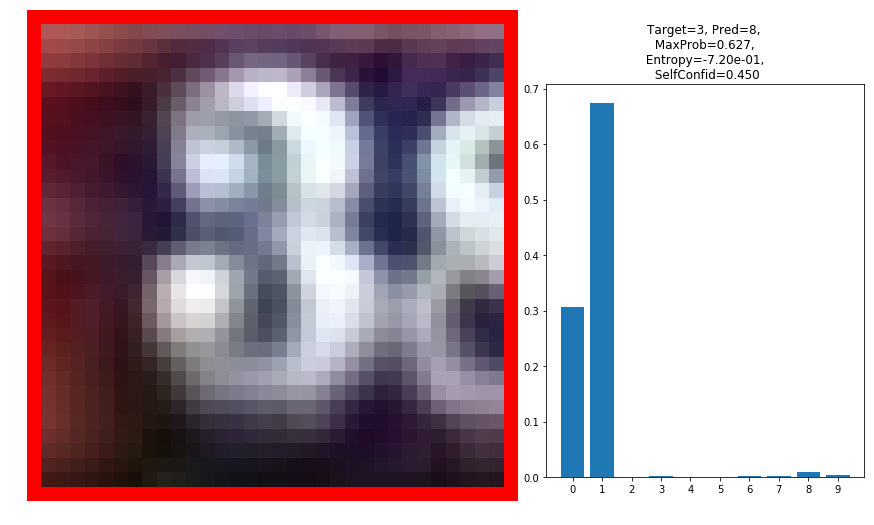

In [146]:

plt.figure(figsize=(15,10))
gridspec.GridSpec(11,5)
plt.subplot2grid((11,5), (0,0), colspan=3, rowspan=11)
plt.axis('off')
plt.imshow(frame_image(np.transpose(dloader.test_loader.dataset.data[top_k_errors[i]],(1,2,0)),'red'))


plt.subplot2grid((11,5), (2,3), colspan=2, rowspan=8)
plt.title('Target={}, Pred={}, \n MaxProb={:.3f}, \n Entropy={:.2e}, \n SelfConfid={:.3f}'
          .format(dloader.test_loader.dataset.labels[top_k_errors[i]],total_probs_normal[top_k_errors[i]].argmax(),
                  total_probs_normal[top_k_errors[i]].max(), metrics_normal.proba_pred[top_k_errors[i]], 
                  metrics_selfconfid.proba_pred[top_k_errors[i]]))
plt.bar([0,1,2,3,4,5,6,7,8,9], total_probs_normal[top_k_errors[4]])
plt.xticks([0,1,2,3,4,5,6,7,8,9])
plt.show()

In [47]:
total_probs_normal[top_k_accurate1[j1]]

array([0.00151146, 0.03668291, 0.03633174, 0.01700741, 0.00196225,
       0.01773182, 0.00344724, 0.8156206 , 0.00236686, 0.06733765],
      dtype=float32)

In [51]:
((total_probs_normal[top_k_accurate1[j1]] * np.log(total_probs_normal[top_k_accurate1[j1]] + 1e-9)).sum())

-0.7863002

In [52]:
((total_probs_normal[top_k_errors[i1]] * np.log(total_probs_normal[top_k_errors[i1]] + 1e-9)).sum())

-0.78726393

In [53]:
total_probs_normal[top_k_errors[i1]]

array([7.1478152e-04, 5.0542871e-03, 5.9564024e-01, 4.1610077e-03,
       3.2180988e-03, 2.2415849e-03, 3.0445401e-04, 3.8511249e-01,
       2.8194312e-03, 7.3359348e-04], dtype=float32)